In [160]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchtext
import torchinfo
import torchtext.transforms as T
from torch import nn
from torch.utils.data import DataLoader
from torchlake.common.schemas import NlpContext
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.metrics.classification import IncrementalConfusionMatrix
from torchlake.sequence_data.models import LstmClassifier
from torchtext.data.utils import get_tokenizer
from torchlake.common.utils.text import build_vocab
from tqdm import tqdm

In [161]:
torch.__version__

'2.1.0+cu118'

In [162]:
torchtext.__version__

'0.16.0+cpu'

# setting


In [163]:
batch_size = 512
context = NlpContext()

In [164]:
tokenizer = get_tokenizer("basic_english")

In [165]:
artifact_path = Path("../../artifacts/lstm")
dataset_path = Path("../../data/AGNews")

# dataset


In [166]:
def datapipe_factory(datapipe, transform=None):
    datapipe = (
        datapipe
            .map(lambda item: (item[0], item[1].strip()))
            .map(lambda item: (item[0], item[1].lower()))
            .filter(lambda item: len(item[1]) > context.min_seq_len)
            .map(lambda item: (item[0], tokenizer(item[1])))
        # .map(lambda text: drop_keywords(text, stopwords.words('english')))
        # .filter(lambda tokens: drop_short_text(tokens, context_size))
    )

    if transform:
        datapipe = datapipe.map(lambda item: (item[0], transform(item[1])))

    return datapipe

In [167]:
train_datapipe, test_datapipe = torchtext.datasets.AG_NEWS(dataset_path.as_posix())

In [168]:
vocab = build_vocab(map(lambda x: x[1], datapipe_factory(train_datapipe)))

d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\utils\data\datapipes\utils\common.py:141: UserWarning: Local function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(


In [169]:
text_transform = T.Sequential(
    T.VocabTransform(vocab),
    T.Truncate(context.max_seq_len - 2),
    T.AddToken(token=context.bos_idx, begin=True),
    T.AddToken(token=context.eos_idx, begin=False),
    T.ToTensor(),
    T.PadTransform(context.max_seq_len, context.padding_idx),
)

In [170]:
train_datapipe = datapipe_factory(
    train_datapipe,
    text_transform,
)

test_datapipe = datapipe_factory(
    test_datapipe,
    text_transform,
)

In [171]:
def collate_fn(batch: list):
    text_placeholder, label_placeholder = [], []
    for label, text in batch:
        text_placeholder.append(text)
        label_placeholder.append(label)

    return torch.stack(text_placeholder), torch.Tensor(label_placeholder)

In [172]:
train_dataloader = DataLoader(
    train_datapipe,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True,
)

test_dataloader = DataLoader(
    test_datapipe,
    batch_size=batch_size,
    collate_fn=collate_fn,
)

In [173]:
for text, label in train_dataloader:
    print(text.shape, label.shape)
    break

torch.Size([512, 256]) torch.Size([512])


# model


In [174]:
vocab_size = len(vocab)
vocab_size

30335

In [175]:
label_size = 4

In [176]:
device = torch.device(context.device)

In [177]:
embed_dim = 256
hidden_dim = 256
model = LstmClassifier(
    vocab_size,
    embed_dim,
    hidden_dim,
    label_size,
    num_layers=1,
    context=context,
).to(device)

In [178]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
LstmClassifier                           --
├─Embedding: 1-1                         7,765,760
├─LSTM: 1-2                              2,105,344
├─LayerNorm: 1-3                         512
├─Linear: 1-4                            1,028
Total params: 9,872,644
Trainable params: 9,872,644
Non-trainable params: 0

In [179]:
criterion = nn.CrossEntropyLoss(ignore_index=context.padding_idx)
optimizer = torch.optim.Adam(model.parameters())

In [180]:
epoches = 10

In [181]:
model.train()
training_loss = []
for epoch in range(epoches):
    running_loss = 0.0
    batch_idx = 0
    for text, label in tqdm(train_dataloader):
        optimizer.zero_grad()

        text = text.to(device)
        label = label.to(device)
        output = model(text)

        loss = criterion(output, label.long() - 1)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()
        batch_idx += 1

    mean_running_loss = running_loss / batch_idx
    training_loss.append(mean_running_loss)
    print(f"epoch {epoch+1} : {mean_running_loss}")

0it [00:00, ?it/s]d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\utils\data\datapipes\iter\combining.py:333: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
235it [00:35,  6.55it/s]


epoch 1 : 0.6079397223097213


235it [00:33,  6.92it/s]


epoch 2 : 0.17800180461812526


235it [00:33,  7.02it/s]


epoch 3 : 0.12073344905325707


235it [00:32,  7.15it/s]


epoch 4 : 0.08714607315177614


235it [00:35,  6.68it/s]


epoch 5 : 0.0689231009480167


235it [00:35,  6.56it/s]


epoch 6 : 0.053075434943225155


235it [00:36,  6.41it/s]


epoch 7 : 0.03888517714283885


235it [00:35,  6.53it/s]


epoch 8 : 0.030877368596005948


235it [00:33,  7.00it/s]


epoch 9 : 0.02425937910782213


235it [00:34,  6.83it/s]

epoch 10 : 0.020805485687278052


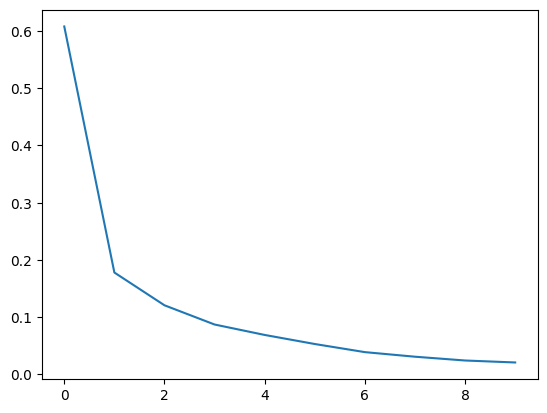

In [189]:
plt.plot(training_loss)

# inference


In [188]:
evaluator = ClassificationEvaluator(label_size, device)

In [190]:
with torch.no_grad():
    model.eval()

    confusion_matrix = IncrementalConfusionMatrix(label_size)
    for text, label in tqdm(test_dataloader):
        text = text.to(device)

        output = model(text).argmax(dim=-1)

        confusion_matrix.update(
            label.long().view(-1).numpy() -1 ,
            output.view(-1).detach().cpu().numpy(),
        )

    print(confusion_matrix)

15it [00:01,  7.93it/s]

[[1773   39   88    0]
 [  20 1851   29    0]
 [  71   18 1811    0]
 [ 417   92 1391    0]]


In [191]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(("World", "Sports", "Business", "Sci/Tech") , per_class_acc)

World     : 0.9331578947368421
Sports    : 0.9742105263157895
Business  : 0.9531578947368421
Sci/Tech  : 0.0


In [192]:
per_class_acc.mean()

0.7151315789473685

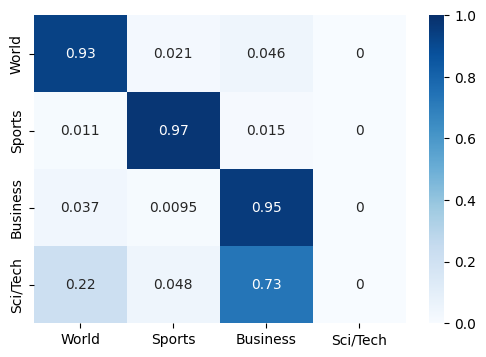

In [193]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    ("World", "Sports", "Business", "Sci/Tech"),
    "Blues",
    annot=True,
    figsize=(6, 4),
)

In [153]:
model_path = artifact_path.joinpath("lstm.pth")

In [154]:
torch.save(model.state_dict(), model_path)

In [58]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>